In [16]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [17]:
import re

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [18]:
tokens = tokenize(text)

def mapping(tokens):
    word2id = {}
    id2word = {}
    for i, token in enumerate(set(tokens)):
        word2id[token] = i
        id2word[i] = token
    return word2id, id2word

In [19]:
word_to_id, id_to_word = mapping(tokens)
word_to_id

{'order': 0,
 'vision': 1,
 'used': 2,
 'make': 3,
 'where': 4,
 'it': 5,
 'being': 6,
 'as': 7,
 'training': 8,
 'develop': 9,
 'difficult': 10,
 'automatically': 11,
 'predictions': 12,
 'decisions': 13,
 'tasks': 14,
 'such': 15,
 'subset': 16,
 'seen': 17,
 'programmed': 18,
 'mathematical': 19,
 'intelligence': 20,
 'learning': 21,
 'algorithms': 22,
 'machine': 23,
 'without': 24,
 'applications': 25,
 'that': 26,
 'experience': 27,
 'in': 28,
 'is': 29,
 'known': 30,
 'based': 31,
 'or': 32,
 'conventional': 33,
 'wide': 34,
 'build': 35,
 'variety': 36,
 'infeasible': 37,
 'needed': 38,
 'the': 39,
 'study': 40,
 'of': 41,
 'through': 42,
 'filtering': 43,
 'so': 44,
 'email': 45,
 'and': 46,
 'are': 47,
 'perform': 48,
 'do': 49,
 'model': 50,
 'computer': 51,
 'on': 52,
 'artificial': 53,
 'explicitly': 54,
 'to': 55,
 'sample': 56,
 'data': 57,
 'a': 58,
 'improve': 59}

## Word2vec Steps

+ **Tokenization:** First, the text is split into individual words or tokens.

+ **Numerical Encoding:** Each token is converted into a numerical format, often using one-hot encoding, to make it suitable for machine learning models.

+ **Creating Input-Target Pairs:** For each word in the text, pairs are formed with neighboring words within a specified window size. For example, with a window size of 2:

**Sentence:** "The quick brown fox jumps over the lazy dog"

**Pairs:** ("quick", "The"), ("quick", "brown"), ("brown", "quick"), ("brown", "fox"), etc.

This approach helps the model learn the context in which words appear.

In [21]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [13]:
def one_hot_encode(idx, vocab_size):
    encoding = [0] * vocab_size
    encoding[idx] = 1
    return encoding

In [14]:
import numpy as np

np.random.seed(42)

def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
            
    
    return np.asarray(X), np.asarray(y)

**Generate Training Data**

In [22]:
X, y = generate_training_data(tokens, word_to_id, 2)

In [23]:
X.shape

(330, 60)

In [34]:
y.shape

(330, 60)

# Embedding Model

### Initializing the Network

In [30]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

### Softmax Function (Making Predictions Probabilities)

In [32]:
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)  # Exponentiate each value
        res.append(exp / exp.sum())  # Normalize to sum 1 (probabilities)
    return res

### Forward Propagation (How Predictions Are Made)

In [31]:
def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache

### Backpropagation (How the Model Learns)

In [35]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

In [36]:
def backward(model, X, y, alpha):
    cache = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    
    assert(dw2.shape == model["w2"].shape)  
    assert(dw1.shape == model["w1"].shape)
    
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)   

## Testing the Model

In [41]:
model = init_network(len(word_to_id), 10)

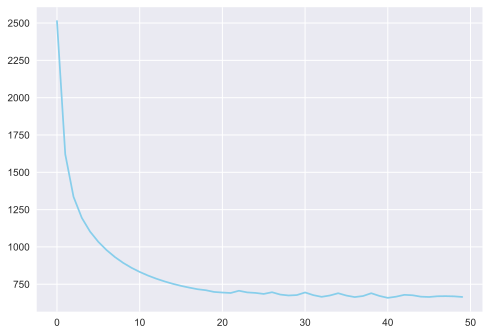

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8')

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [56]:
# print the probability of the next word similar to word "learning"

learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]
result

array([2.23971493e-03, 3.58044519e-04, 7.70129009e-04, 1.02730629e-05,
       7.21419054e-04, 7.47685984e-03, 7.76207392e-05, 7.41161463e-04,
       1.49152984e-04, 2.66934244e-03, 4.16189534e-03, 1.91425837e-03,
       1.73537146e-03, 2.58470042e-05, 1.49962494e-04, 3.25968912e-07,
       2.57174055e-06, 7.13951510e-04, 5.82888672e-05, 2.89447025e-03,
       8.94145379e-02, 3.91563037e-02, 5.37730954e-02, 3.62575859e-01,
       9.93613418e-05, 3.40307377e-06, 1.05101429e-03, 1.62321403e-03,
       1.58467114e-05, 6.91293176e-02, 5.47535110e-06, 1.13383354e-03,
       7.63099147e-04, 1.53440971e-03, 7.35287726e-05, 7.49009854e-02,
       3.33769623e-06, 2.47346462e-03, 3.72031694e-03, 7.41538888e-02,
       5.54139551e-05, 6.71178715e-05, 7.59299587e-04, 2.35633817e-06,
       9.83757475e-02, 2.10536895e-05, 1.19600387e-04, 7.42456107e-02,
       6.18843108e-04, 4.10461168e-03, 8.97104190e-03, 2.74322488e-04,
       5.66501799e-04, 1.56568549e-03, 1.34439614e-04, 2.26381870e-04,
      

In [50]:
for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
so
intelligence
build
are
the
is
algorithms
learning
model
it
sample
difficult
do
needed
mathematical
improve
develop
infeasible
order
automatically
predictions
experience
artificial
conventional
based
that
used
or
through
as
where
seen
perform
on
vision
computer
to
tasks
training
explicitly
and
without
being
wide
of
programmed
study
a
data
decisions
email
in
make
known
applications
variety
subset
filtering
such


### Embedding

In [53]:
# embedding lies in the first layer of the network
embedding = model["w1"]
print(embedding)

[[-0.73455808 -1.95952287 -1.99419337  1.27607141 -0.42865796  1.38119296
   0.3989247  -0.89143737 -1.14301121  1.66284393]
 [ 2.20715372  0.04102283  0.60555398 -1.02035512  0.14275155 -1.46879904
   1.26314935 -0.01227235  1.09026655 -0.32913753]
 [-0.53997798  0.86591937 -0.76996046  1.09017968  0.58420161 -0.72287789
   1.41047817  0.50268796 -2.3531369   0.91471381]
 [ 0.25375742 -0.25041468 -2.1036851  -1.5308171  -0.81591019 -0.75829322
   0.43052833  0.70048637 -0.38346059  0.63308556]
 [ 1.2784859  -0.51053144  0.53775838 -1.05802756  1.67893629 -0.50184892
   1.6771135   1.0981218   1.17603826 -0.48383059]
 [-0.01360907 -1.17076059  0.56590053 -0.38338438  0.50456449 -0.78610019
  -0.6762309   0.90148095  0.10927096 -2.94307564]
 [ 0.74794402  0.88793239 -0.57111911  1.47459154 -1.5089124  -1.48119053
   0.04261743 -0.87021315  1.93943898 -0.07413765]
 [-0.49406404 -2.32163633  0.35459446 -0.18892205  1.18554586  0.19798496
   0.29261291 -0.33758838 -1.16156222 -0.01352996]


In [57]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [58]:
get_embedding(model, "artificial")

array([ 1.37286779,  1.4025884 ,  0.95563157, -0.18818597, -1.46694169,
       -0.62928053,  2.90394238, -0.49055987,  0.61865827,  0.55148336])